# Reinforcement Learning

Name: Naser Kazemi

Student ID: 99102059

In this notebook we learn how to use value-based reinforcement learning algorithms on the [CliffWalking-v0](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) task from [Gymnasium](https://gymnasium.farama.org/).

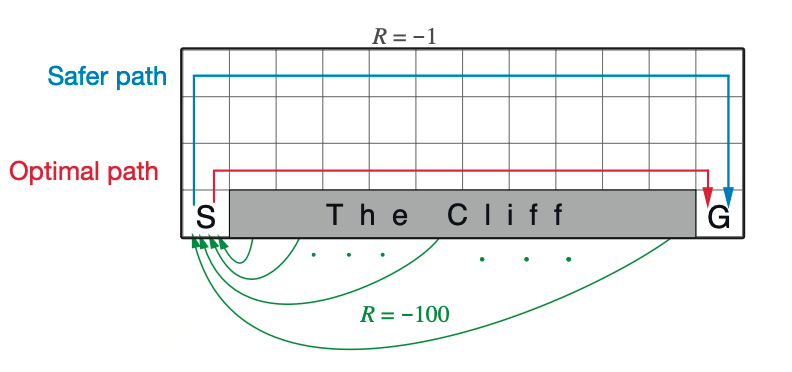

# Setup

We must first install the required packages.

In [1]:
!sudo apt-get update --quiet
!pip install 'imageio==2.4.0' --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip3 install gymnasium[classic_control] --quiet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [808 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,082 kB]
Get:13 http://archive.ubu

Next we must import the following libraries.

In [2]:
import gymnasium as gym
import random
import base64
import imageio
import IPython
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve as conv

Here are some helper functions which will allow you to plot the training process and see the results by visualizign the gym environment.

In [3]:
# @title helper and plotting functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1, fps=5, max_steps=48):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while max_steps >= 0:
                action = policy(state, Q)
                state, reward, terminated, truncated, info = env.step(action)
                max_steps -= 1
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_heatmap(env, value, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        fig, ax = plt.subplots()
    dim_x, dim_y = 12, 4
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    labels[37:-1], labels[-1] = ' ', 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
    if show:
        plt.show()
    return im


def plot_rewards(rewards, average_range=10, log=False, ax=None, show=False):
    # Generate plot showing total reward accumulated in each episode.
    n_episodes = len(rewards)
    if log:
        rewards = np.log10(-rewards)
    if ax is None:
        fig, ax = plt.subplots()
    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
    ax.plot(range(0, n_episodes, average_range), smoothed_rewards[0:n_episodes:average_range])
    ylab = 'Log of negative sum of rewards' if log else 'Total reward'
    ax.set(xlabel='Episodes', ylabel=ylab)
    if show:
      plt.show()


def plot_performance(env, value, reward_sums, log=False):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
    plot_rewards(reward_sums, ax=axes[0], log=log)
    plot_heatmap(env, value, ax=axes[1])
    plt.show(fig)

# Explore the Environment (5 points)

First we must create the environment. In order to be able to render the environment we must use `rgb_array` as the render mode.

In [4]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')

# TODO: Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Discrete(48)
Actions: Discrete(4)


Define a random policy that randomly selects an action from the action space. (Note that the environment has been defined globally)

In [11]:
def random_policy(state, Q):
    # TODO: Select and return a random action
    return env.action_space.sample()

Visualize the random policy.

In [ ]:
create_policy_eval_video(env, random_policy, 'random_policy', max_steps=200)

# Policies (5 points)

First define a policy that takes a state $s$ and returns the action $a$ with the highest $Q(s,a)$.

In [5]:
def greedy_policy(state, Q):
    """Greedy policy: selects the maximum value action.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)

    Returns:
      action (integer): the chosen action
    """
    max_value_action = np.argmax(Q[state])
    return max_value_action

Now define a policy that selects a greedy action with probability $1-\varepsilon$ and selects a random action with probability $\varepsilon$, for given a constant $\varepsilon$.

In [6]:
def epsilon_greedy(state, Q, epsilon):
    """Epsilon-greedy policy: selects the maximum value action with probabilty
        (1-epsilon) and selects randomly with epsilon probability.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)
      epsilon (float): probability of selecting an action randomly

    Returns:
      action (integer): the chosen action
    """
    if np.random.random() < epsilon:
        return random_policy(state, Q)
    else:
        return greedy_policy(state, Q)

# Evaluate the Models (5 points)

In order to evaluate our models, we use the following function to measure the average reward and it's standard deviation.

In [7]:
def evaluate_policy(env, Q, num_episodes=10, max_steps=100):
    # Initialize sum of rewards
    total_rewards = []

    for episode in range(num_episodes):
        # Initialize environment
        state, info = env.reset()
        episode_reward = 0

        current_steps = 0
        while max_steps > current_steps:
            current_steps += 1
            # Run greedy policy
            action = greedy_policy(state, Q)

            # Take step in the environment
            state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward


            # Break if terminated or truncated
            if terminated or truncated:
                break

        total_rewards.append(episode_reward)


    # Return mean and std of rewards
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return mean_reward, std_reward

# Monte Carlo (30 points)

In this section we wish to train a MC model on the environment. The algorithm we are implementing can be found on the **final page of the session 6 slides**. For more clarity is it recommended that you read these slides.

## Learning (15 points)

First we must write the training loop for our MC algorithm. In this loop we generate a trajectory, list of tuples of (state, action, reward) for each step, for every episode, and then update the Q-values according to the learning rule (which is the MC algorithm). Actions are taken according to an epsilon-greedy policy where $\varepsilon = \max \left( \frac{1}{k}, \varepsilon_{end}\right)$ for the $k$-th episode.

In [8]:
def mc_learn_env(env, learning_rule, n_episodes, gamma, final_eps=0.1):
    # Initialize Q and N
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))
    N = np.zeros((num_states, num_actions))

    # Store sum of rewards for different episodes in learning
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for k in tqdm(range(1, n_episodes + 1)):
        # Update epsilon
        epsilon = max(1 / k, final_eps)
        trajectory, first_visits = list(), dict()
        step_counter, done = 0, False
        state, info = env.reset()
        while not done:
            # Take epsilon-greedy action
            action = epsilon_greedy(state, Q, epsilon)

            # Take a step in the environment
            next_state, reward, terminated, truncated, info = env.step(action)

            # Store the (state, action, reward) tuple in episode trajectory
            trajectory.append((state, action, reward))

            # Update first visits if necessary
            if (state, action) not in first_visits:
                first_visits[(state, action)] = step_counter


            # Go to the next state
            state = next_state

            # Update sum of rewards
            reward_sums[k - 1] += reward

            # Increment the step_counter
            step_counter += 1

            # Update done
            done = terminated

        # Update Q and N
        Q, N = learning_rule(Q, N, trajectory, first_visits, step_counter, gamma)
    return Q, reward_sums

## First-visit MC Online Control (15 points)

Now you must implement the MC algorithm. You can start by initializing $G=0$ and by traversing the trajectory of the episode in reverse. For each state-action pair in this traversal you must update $G$ and update $Q$ and $N$ if it is the first time we are visiting this state-action pair. Finally you must return $Q$ and $N$.

In [9]:
def first_visit_MC_online_control(Q, N, trajectory, first_visits, T, gamma):
    """Q-learning: updates the value function and returns it.

    Args:
      Q (ndarray): current value function of shape (n_states, n_actions)
      N (ndarray): current number of visits of shape (n_states, n_actions)
      trajectory (list): (state, action, reward) tuples from episode
      first_visits (dict): first visit index of (state, action) pairs
      T (int): length of the current episode
      gamma (float): discount factor

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
      N (ndarray): the updated number of visits of shape (n_states, n_actions)
    """
    # Initialize G
    G = 0

    # For each time step:
    for t in range(T - 1, -1, -1):
        state, action, reward = trajectory[t]

        # Update G
        G = gamma * G + reward

        # If first visit of (state, action) pair:
        if first_visits.get((state, action)) == t:


            # Update N(state, action) and Q(state, action)
            N[state, action] += 1
            Q[state, action] += (G - Q[state, action]) / N[state, action]

    # Return Q and N
    return Q, N

Now train the model after setting the hyperparameters.

100%|██████████| 3000/3000 [00:03<00:00, 984.49it/s] 



Monte Carlo mean_reward = -17.00 +/- 0.0000



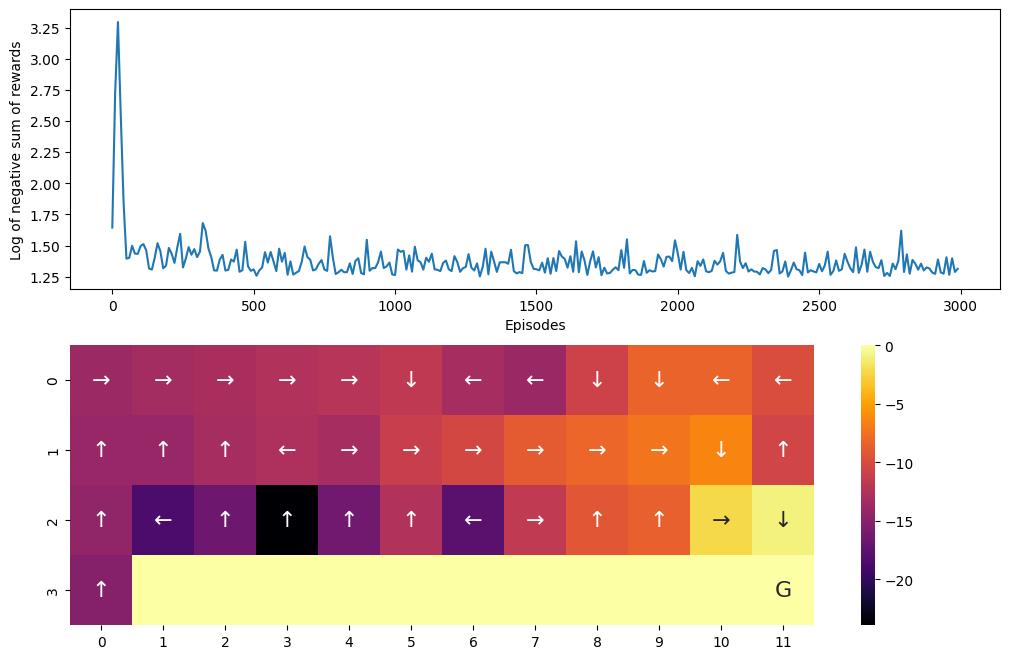

In [13]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

# Set the discount factor
gamma = 0.95

# Set the number of episodes/trials
n_episodes = 3000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using MC Control
results = mc_learn_env(env, first_visit_MC_online_control, n_episodes, gamma)
value_mc, reward_sums_mc = results

# Evaluate MC Control method
mean_reward, std_reward = evaluate_policy(env, value_mc)
print(f"\nMonte Carlo mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_mc, reward_sums_mc, log=True)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Monte Carlo', value_mc)

# Temporal Difference (55 points)

As you've seen, MC methods may have some shortcomings and in this section we wish to use TD methods to overcome some of the challenges we've encountered in the previous section. Since it takes a long time for each episode to end, the learning process in MC is very slow. TD methods, in contrast to MC methods which can only learn after one full episode, can learn from every step within an episode.

We take a look at two different TD algorithms:

*   Q-learning
*   SARSA

Additionally we use the idea of eligibility traces to check the performance of other variants of these algorithms. Eligibility traces are a mechanism for attributing credit or blame for rewards received to actions taken in the past. As a result we also take a look at:

*   Q(λ)
*   SARSA(λ)







## Learning (15 points)

Similar to the MC section, we must first define a learning function. However in TD, unlike MC, we must use the `learning_rule` after each step.

In [14]:
def learn_environment(env, learning_rule, params, max_steps, n_episodes):
    # Initialize Q
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    eligibility_traces = True if 'lambda' in params.keys() else False
    if eligibility_traces: # Initialize E
        E = np.zeros((env.observation_space.n, env.action_space.n))

    # Store sum of rewards for different episodes in learning
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()  # initialize state
        action = epsilon_greedy(state, Q, params['epsilon'])
        for _ in range(max_steps):
            # Take a step in the environment
            next_state, reward, terminated, truncated, info = env.step(action)

            # Take next action
            next_action = epsilon_greedy(next_state, Q, params['epsilon'])

            if eligibility_traces: # Update Q-values and eligibility traces
                Q, E = learning_rule(state, action, reward, next_state, next_action, Q, E, params)
            else: # Update Q-values
                Q = learning_rule(state, action, reward, next_state, next_action, Q, params)
            # Go to the next state
            state = next_state
            action = next_action

            # Update sum of rewards
            reward_sums[episode] += reward

            # Break if terminated or truncated
            if terminated or truncated:
                break

    return Q, reward_sums

## Q-learning (20 points)

In this section we take a look at two algorithms, *Q-learning* and *Q(λ)*.

### Q-learning (10 points)

One of the most famous algorithms for estimating action values is the Temporal Differences (TD) **control** algorithm known as *Q-learning* with the following update rule:

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{equation}

where $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

The expression $r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1})$ is referred to as the TD target while the full expression

\begin{equation}
\delta_t = r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t),
\end{equation}

i.e., the difference between the TD target and the current Q-value, is referred to as the TD error, or reward prediction error.

Because of the max operator used to select the optimal Q-value in the TD target, Q-learning directly estimates the optimal action value, i.e. the cumulative future reward that would be obtained if the agent behaved optimally, regardless of the policy currently followed by the agent. For this reason, Q-learning is referred to as an **off-policy** method.

You can learn more about Q-learning [here](http://incompleteideas.net/book/ebook/node65.html).

In [15]:
def q_learning(state, action, reward, next_state, next_action, Q, params):
    """Q-learning: updates the value function and returns it.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      params (dict): a dictionary containing the default parameters

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    # Compute the TD error
    td_target = reward + params['gamma'] * np.max(Q[next_state])
    td_error = td_target - Q[state, action]

    # TODO: Update the Q-value for the state-action pair
    Q[state, action] += params['alpha'] * td_error

    # Return updated Q-values
    return Q

Now that you have implemented the algorithm, you can define the hyperparameters and proceed to train it.

100%|██████████| 500/500 [00:01<00:00, 474.29it/s]



Q-learning mean_reward = -13.00 +/- 0.0000



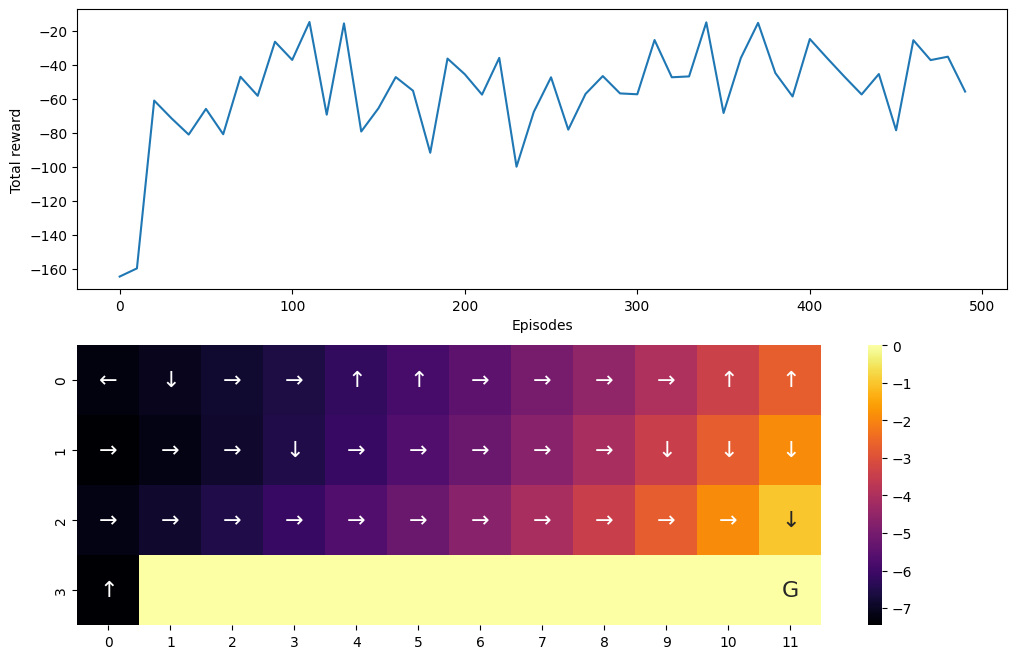

In [18]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

# Set parameters needed by our policy and learning rule
params = {'epsilon': 0.1 ,      # exploration rate
          'alpha': 0.5 ,        # learning rate
          'gamma': 0.9          # discount factor
          }

# Set number of episodes/trials
n_episodes = 500
max_steps = 100

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_q_learning, reward_sums_q_learning = results

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_q_learning)
print(f"\nQ-learning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_q_learning, reward_sums_q_learning)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Q-learning', value_q_learning)

### Q(λ) (10 points)

Two different methods have been proposed that combine eligibility traces and Q-learning; they are called Watkins's *Q(λ)* and Peng's *Q(λ)*, named after the researchers who first proposed them. Here we plan to implement Watkins's *Q(λ)*. These approaches are different in the following ways:

*   Watkins: Zero out eligibility trace after a non-greedy action. Do max
when backing up at first non-greedy choice.
*   Peng: No distinction between exploratory and greedy actions.



Recall that *Q-learning* is an off-policy method, meaning that the policy learned about need not be the same as the one used to select actions. In particular, *Q-learning* learns about the greedy policy while it typically follows a policy involving exploratory actions--occasional selections of actions that are suboptimal according to $Q_t$. Because of this, special care is required when introducing eligibility traces.

In Q(λ), the action values are updated based on a combination of the TD (Temporal Difference) error and eligibility traces. The update rule for Q(λ) is given by:

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \cdot \delta_t \cdot E(s_t,a_t)
\end{equation}

where $\delta_t$ is the TD error at time step $t$ and $E(s_t,a_t)$ is the eligibility trace for action $a_t$ in state $s_t$, which captures the influence of past actions on the current action value estimate.

The eligibility trace $E(s_t,a_t)$ is updated at each time step based on the decay parameter λ and the discount factor γ. Specifically, it is updated as follows:

\begin{equation}
E(s_t,a_t) \leftarrow \gamma \cdot \lambda \cdot E(s_{t-1},a_{t-1}) + 1 (s_t=s,a_t=a)
\end{equation}
Where $E(s_t,a_t) + 1 (s_t=s,a_t=a)$ is the indicator function that equals 1 if the current state-action pair matches the updated state-action pair, and 0 otherwise. Put simply, this value will be set to zero everytime we take a non-greedy action.

By incorporating eligibility traces, Q(λ) can more efficiently update action values based on the observed rewards and make better decisions over time, leading to improved learning performance in reinforcement learning tasks.

You can learn more about Q(λ) [here](http://incompleteideas.net/book/ebook/node78.html).

In [19]:
def q_lambda(state, action, reward, next_state, next_action, Q, E, params):
    """Q-Learning with Eligibility Traces: updates the value function using Q-learning with eligibility traces.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      E (ndarray): eligibility traces of shape (n_states, n_actions)
      params (dict): a dictionary containing the hyperparameters

    Returns:
      Q (ndarray): the updated value function Q of shape (n_states, n_actions)
      E (ndarray): the updated eligibility traces E of shape (n_states, n_actions)
    """

    # Compute TD error
    td_target = reward + params['gamma'] * np.max(Q[next_state])
    td_error = td_target - Q[state, action]

    # Update eligibility trace for the current state-action pair
    E[state, action] += 1

    # Update Q-values and eligibility traces
    Q += params['alpha'] * td_error * E
    E *= params['gamma'] * params['lambda']

    # TODO: Return Q-values and eligibility traces
    return Q, E

Now that you have implemented the algorithm, you can define the hyperparameters and proceed to train it.

100%|██████████| 500/500 [00:01<00:00, 377.12it/s]



Q(λ) mean_reward = -13.00 +/- 0.0000



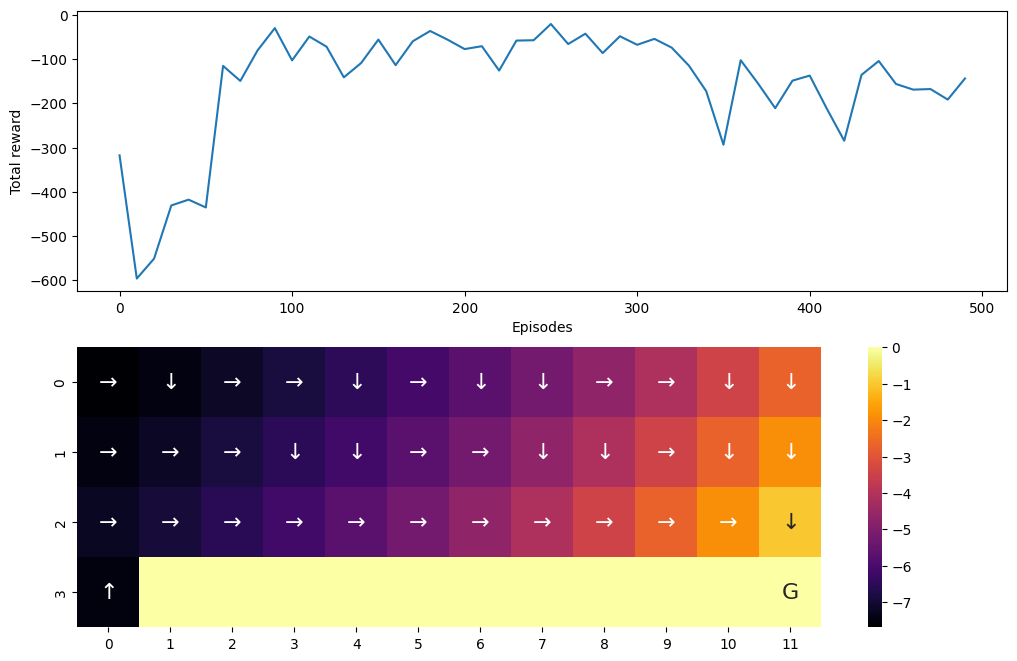

In [20]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

# Set parameters needed by our policy and learning rule
params = {'epsilon': 0.3,      # exploration rate
          'alpha': 0.7,        # learning rate
          'gamma': 0.9,        # discount factor
          'lambda': 0.8         # trace parameter
          }

# Set number of episodes/trials
n_episodes = 500
max_steps = 200

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using Q(λ)
results = learn_environment(env, q_lambda, params, max_steps, n_episodes)
value_q_lambda, reward_sums_q_lambda = results

# Evaluate Q(λ)
mean_reward, std_reward = evaluate_policy(env, value_q_lambda)
print(f"\nQ(λ) mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_q_lambda, reward_sums_q_lambda)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Q(λ)', value_q_lambda)

## SARSA (20 points)

In this section we take a look at two algorithms, SARSA and SARSA(λ).

### SARSA (10 points)

An alternative to Q-learning, the SARSA algorithm also estimates action values. However, rather than estimating the optimal (off-policy) values, SARSA estimates the **on-policy** action value, i.e. the cumulative future reward that would be obtained if the agent behaved according to its current beliefs. The update rule of SARSA is:

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{equation}

where, once again, $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

In fact, you will notice that the *only* difference between Q-learning and SARSA is the TD target calculation uses the policy to select the next action (in our case epsilon-greedy) rather than using the action that maximizes the Q-value.

You can learn more about SARSA [here](http://incompleteideas.net/book/ebook/node64.html).

In [22]:
def sarsa(state, action, reward, next_state, next_action, Q, params):
    """SARSA: updates the value function and returns it.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      params (dict): a dictionary containing the default parameters

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    # Compute the TD error
    td_target = reward + params['gamma'] * Q[next_state, next_action]
    td_error = td_target - Q[state, action]

    # Update the Q-value for the state-action pair
    Q[state, action] += params['alpha'] * td_error

    # Return updated Q-values
    return Q

Now that you have implemented the algorithm, you can define the hyperparameters and proceed to train it.

100%|██████████| 500/500 [00:00<00:00, 1200.26it/s]



SARSA mean_reward = -15.00 +/- 0.0000



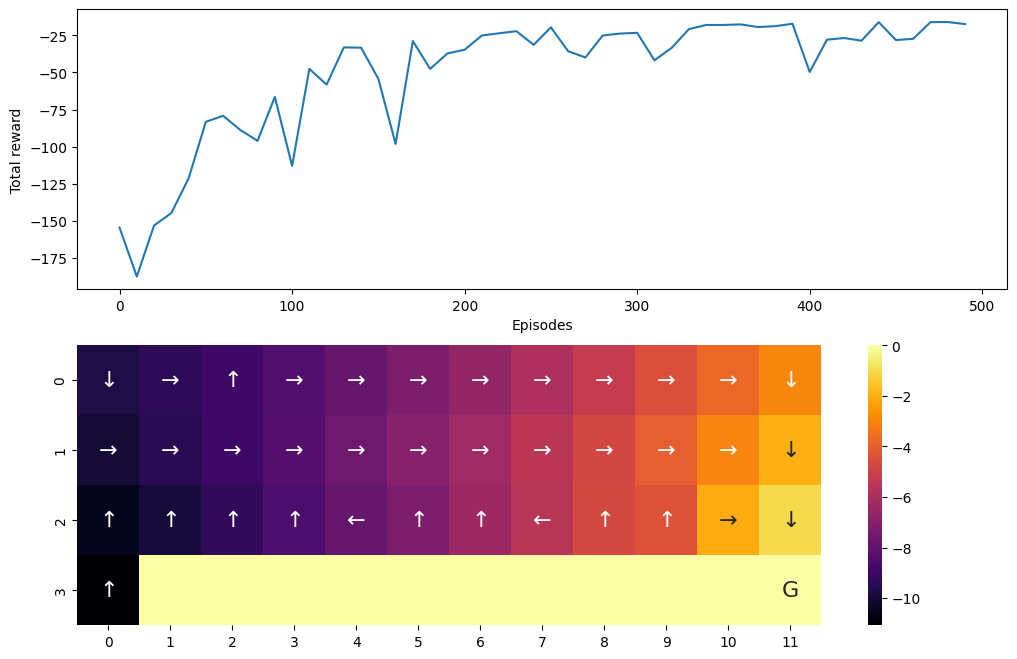

In [24]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

# Set parameters needed by our policy and learning rule
params = {'epsilon': 0.1,      # exploration rate
          'alpha': 0.1,        # learning rate
          'gamma': 0.95        # discount factor
          }

# Set number of episodes/trials
n_episodes =  500
max_steps = 100

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using SARSA
results = learn_environment(env, sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)

### SARSA(λ) (10 points)

SARSA(λ) is an extension of the SARSA algorithm that incorporates eligibility traces to update the action values. Similar to SARSA, it estimates on-policy action values, but it also considers the influence of future actions on the learning process. The key addition in SARSA(λ) is the use of eligibility traces, which allow the algorithm to assign credit or blame to actions based on their contribution to the observed rewards over multiple time steps.

The update rule for SARSA(λ) involves updating the action values based on a combination of TD errors and eligibility traces. Here's the update rule:

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \cdot \delta_t \cdot E(s_t,a_t)
\end{equation}

where $\delta_t = r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)$ is the TD error at time step $t$ and $E(s_t,a_t)$ is the eligibility trace for action $a_t$ in state $s_t$, which captures the influence of past actions on the current action value estimate.

The eligibility trace $E(s_t,a_t)$ is updated at each time step based on the decay parameter λ and the discount factor γ. Specifically, it is updated as follows:

\begin{equation}
E(s_t,a_t) \leftarrow \gamma \cdot \lambda \cdot E(s_{t-1},a_{t-1})  + 1
\end{equation}

SARSA(λ) combines the advantages of SARSA and TD(λ), offering a balance between online and offline learning. By incorporating eligibility traces, SARSA(λ) can learn more efficiently from delayed rewards and make better decisions over time.

You can learn more about SARSA(λ) [here](http://incompleteideas.net/book/ebook/node77.html).

In [25]:
def sarsa_lambda(state, action, reward, next_state, next_action, Q, E, params):
    """SARSA(λ): updates the value function using SARSA(λ) algorithm.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      E (ndarray): eligibility traces of shape (n_states, n_actions)
      params (dict): a dictionary containing the hyperparameters

    Returns:
      Q (ndarray): the updated value function Q of shape (n_states, n_actions)
      E (ndarray): the updated eligibility traces E of shape (n_states, n_actions)
    """

    # Compute the TD error
    td_target = reward + params['gamma'] * Q[next_state, next_action]
    td_error = td_target - Q[state, action]

    # Update eligibility traces
    E[state, action] += 1

    # Update Q-values and eligibility traces using SARSA(λ) update rule
    Q += params['alpha'] * td_error * E
    E *= params['gamma'] * params['lambda']

    # Return Q-values and eligibility traces
    return Q, E

Now that you have implemented the algorithm, you can define the hyperparameters and proceed to train it.

100%|██████████| 500/500 [00:00<00:00, 1008.05it/s]



SARSA(λ) mean_reward = -17.00 +/- 0.0000



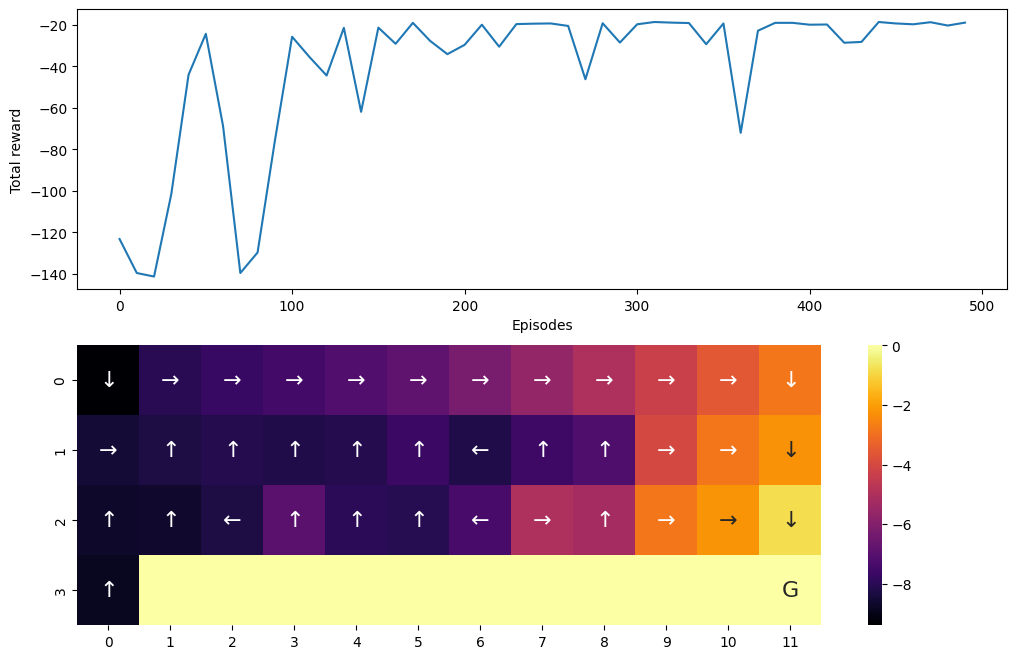

In [28]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

# Set parameters needed by our policy and learning rule
params = {'epsilon': 0.1,      # exploration rate
          'alpha': 0.1,        # learning rate
          'gamma': 0.9,        # discount factor
          'lambda': 0.7         # trace parameter
          }

# Set number of episodes/trials
n_episodes = 500
max_steps = 100

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using SARSA(λ)
results = learn_environment(env, sarsa_lambda, params, max_steps, n_episodes)
value_sarsa_lambda, reward_sums_sarsa_lambda = results

# Evaluate SARSA(λ)
mean_reward, std_reward = evaluate_policy(env, value_sarsa_lambda)
print(f"\nSARSA(λ) mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa_lambda, reward_sums_sarsa_lambda)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA(λ)', value_sarsa_lambda)